## **1.0 Initial Setup and Database Connection**

**1.1 Imports**

In [18]:
import influxdb
from datetime import datetime
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

**1.2 Connection**

In [19]:
# Connecting to influxDB
HOST = 'influx.linklab.virginia.edu'
PORT = 443
USERNAME = 'sahbf24'
PASSWORD = 'raighee7Ahpheej3eud2sheob7seey7'
DATABASE = 'gateway-generic'

client = influxdb.InfluxDBClient(HOST, PORT, USERNAME, PASSWORD, DATABASE, ssl=True, verify_ssl=True)

## **2.0 Data Exploration and Historical Data Extraction**

**2.1 Testing Query + data output format**

In [18]:
query = """
    SELECT SUM("value") / 60000 AS "kWh"
    FROM "power_w"
    WHERE "location_specific" =~ /^([0-9]+ Olsson)$/
    AND time >= now() - 5w
    GROUP BY time(1w), "location_specific" FILL(0)
"""

result = client.query(query)

# put results in df and make column location_specific

rows = []
for (measurement, tags), points in result.items():
    location = tags.get('location_specific', 'Unknown')
    for p in points:
        rows.append({
            'time': pd.to_datetime(p['time']),
            'location_specific': location,
            'energy_kWh': round(p.get('kWh', 0), 2) # Convert kWh to MWh
        })

df = pd.DataFrame(rows)
df.sort_values(['location_specific', 'time'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Add an incremental week counter (starts at 1)
df['week'] = df.groupby('location_specific').cumcount() + 1

df.head(20)


,time,location_specific,energy_kWh,week
0,2025-10-02 00:00:00+00:00,200 Olsson,0.00,1
1,2025-10-09 00:00:00+00:00,200 Olsson,0.00,2
2,2025-10-16 00:00:00+00:00,200 Olsson,0.00,3
3,2025-10-23 00:00:00+00:00,200 Olsson,0.00,4
4,2025-10-30 00:00:00+00:00,200 Olsson,0.08,5
5,2025-11-06 00:00:00+00:00,200 Olsson,-0.00,6
6,2025-10-02 00:00:00+00:00,201 Olsson,144.36,1
7,2025-10-09 00:00:00+00:00,201 Olsson,162.18,2
8,2025-10-16 00:00:00+00:00,201 Olsson,149.68,3
9,2025-10-23 00:00:00+00:00,201 Olsson,214.91,4


**2.2 Graphing energy consumption test**

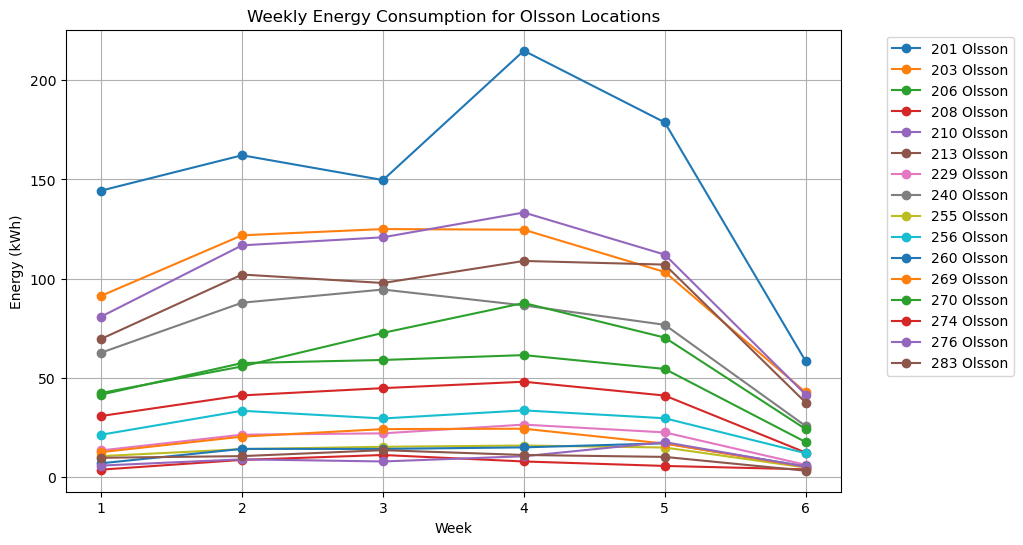

In [26]:
# filter dataset to remove rooms where energy levels are below 10 kWh for all weeks
filtered_df = pd.DataFrame()
for location, group in df.groupby('location_specific'):
    if group['energy_kWh'].max() >= 10:
        filtered_df = pd.concat([filtered_df, group], ignore_index=True)

# graph all locations on one line plot
fig, ax = plt.subplots(figsize=(10, 6))
for location, group in filtered_df.groupby('location_specific'):
    ax.plot(group['week'], group['energy_kWh'], marker='o', label=location)
ax.set_xlabel('Week')
ax.set_ylabel('Energy (kWh)')
ax.set_title('Weekly Energy Consumption for Olsson Locations')
ax.legend()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

**2.3 Gathering all historical energy data**

In [44]:
query = """
    SELECT SUM("value") / 60000 AS "kWh"
    FROM "power_w"
    WHERE "location_specific" =~ /^([0-9]+ Olsson)$/
    AND time >= '2022-01-01T00:00:00Z'
    AND time <= '2025-11-01T00:00:00Z'
    GROUP BY time(1w), "location_specific" FILL(0)
"""

result = client.query(query)

# put results in hist_energy and make column location_specific

rows = []
for (measurement, tags), points in result.items():
    location = tags.get('location_specific', 'Unknown')
    for p in points:
        rows.append({
            'time': pd.to_datetime(p['time']),
            'location_specific': location,
            'energy_kWh': round(p.get('kWh', 0), 2) # Convert kWh to MWh
        })

hist_energy = pd.DataFrame(rows)
hist_energy.sort_values(['location_specific', 'time'], inplace=True)
hist_energy.reset_index(drop=True, inplace=True)

# Add an incremental week counter (starts at 1)
hist_energy['week'] = hist_energy.groupby('location_specific').cumcount() + 1

hist_energy.head(20)

,time,location_specific,energy_kWh,week
0,2021-12-30 00:00:00+00:00,200 Olsson,0.00,1
1,2022-01-06 00:00:00+00:00,200 Olsson,0.00,2
2,2022-01-13 00:00:00+00:00,200 Olsson,0.00,3
3,2022-01-20 00:00:00+00:00,200 Olsson,0.02,4
4,2022-01-27 00:00:00+00:00,200 Olsson,0.20,5
5,2022-02-03 00:00:00+00:00,200 Olsson,0.00,6
6,2022-02-10 00:00:00+00:00,200 Olsson,0.01,7
7,2022-02-17 00:00:00+00:00,200 Olsson,0.13,8
8,2022-02-24 00:00:00+00:00,200 Olsson,0.02,9
9,2022-03-03 00:00:00+00:00,200 Olsson,0.00,10


In [51]:
# save unfilitered historical data to csv
hist_energy.to_csv('olsson_historical_energy.csv', index=False)

**2.4 Gathering Nighttime data and graphing**

In [25]:
# testing to see what room data is available

query = """
    SELECT SUM("value") / 60000 AS "kWh"
    FROM "power_w"
    WHERE "location_specific" =~ /^([0-9]+ Olsson)$/
    AND time >= '2025-11-19T16:00:00Z'
    AND time <= '2025-11-20T11:00:00Z'
    GROUP BY time(1h), "location_specific" FILL(0)
"""

result = client.query(query)

# put results in df and make column location_specific

rows = []
for (measurement, tags), points in result.items():
    location = tags.get('location_specific', 'Unknown')
    for p in points:
        rows.append({
            'time': pd.to_datetime(p['time']),
            'location_specific': location,
            'energy_kWh': round(p.get('kWh', 0), 2) # Convert kWh to MWh
        })

night_df = pd.DataFrame(rows)
night_df.sort_values(['location_specific', 'time'], inplace=True)
night_df.reset_index(drop=True, inplace=True)

# gets the hour from the time column
night_df['hour'] = night_df['time'].dt.hour

night_df.head(20)

,time,location_specific,energy_kWh,hour
0,2025-11-19 16:00:00+00:00,200 Olsson,-0.0,16
1,2025-11-19 17:00:00+00:00,200 Olsson,0.0,17
2,2025-11-19 18:00:00+00:00,200 Olsson,0.0,18
3,2025-11-19 19:00:00+00:00,200 Olsson,0.0,19
4,2025-11-19 20:00:00+00:00,200 Olsson,0.0,20
5,2025-11-19 21:00:00+00:00,200 Olsson,0.0,21
6,2025-11-19 22:00:00+00:00,200 Olsson,0.0,22
7,2025-11-19 23:00:00+00:00,200 Olsson,0.0,23
8,2025-11-20 00:00:00+00:00,200 Olsson,0.0,0
9,2025-11-20 01:00:00+00:00,200 Olsson,0.0,1


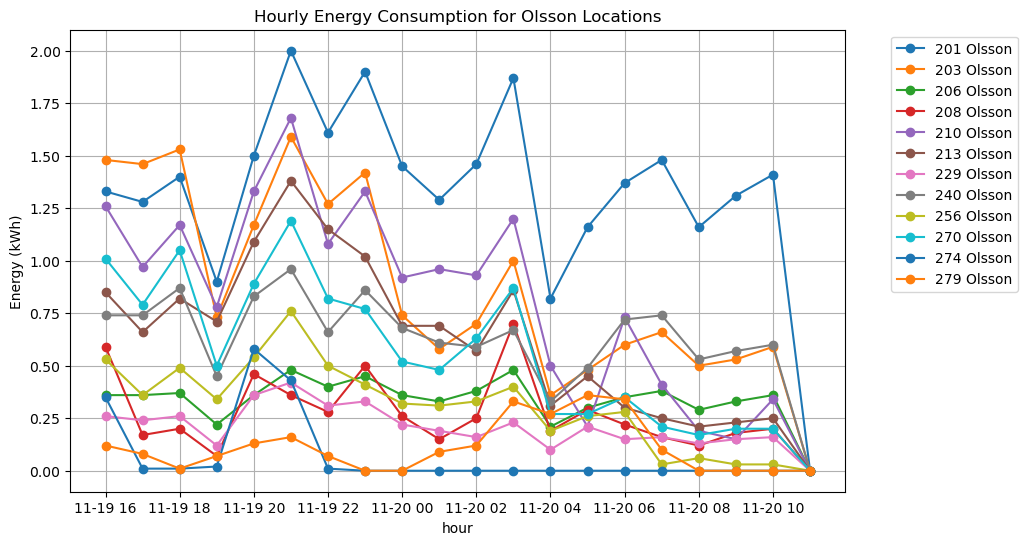

In [ ]:
# filter dataset to remove rooms where energy levels are low
flitered_night = pd.DataFrame()
for location, group in night_df.groupby('location_specific'):
    if group['energy_kWh'].max() >= 0.3:
        flitered_night = pd.concat([flitered_night, group], ignore_index=True)
    # removes last time step where all values are 0
    

# graph all locations on one line plot
fig, ax = plt.subplots(figsize=(10, 6))
for location, group in flitered_night.groupby('location_specific'):
    ax.plot(group['time'], group['energy_kWh'], marker='o', label=location)
ax.set_xlabel('hour')x
ax.set_ylabel('Energy (kWh)')
ax.set_title('Hourly Energy Consumption for Olsson Locations')
ax.legend()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

## **3.0 Night-time Anomaly Detection**

**3.1 Defining Global Parameters**

- `night start/end`: defines start and end time for anomaly detection
- `Z_thresh`: the minimum stdev required to be flagged as an anomaly for model 1
- `Rolling_lookback_days`: the amount of data aggregated to form a rolling avg/stdev that is used for model 1
- `Kmeans_clusters`: 2 clusters are picked for the ML model. One cluster represents "normal" data while the other repreents anomalies
- `Min_persist_minutes`: Used to filter out small events, whether intentional or random, from the models (ex. flickering lights, appliance reseting, printer being used from another room)

In [118]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Any, List, Optional
import random

# -------------------------
# Config / constants
# -------------------------
TIME_COL = "time"
ROOM_COL = "location_specific"
ENERGY_COL = "energy_kWh"

# Night definition (you can change)
NIGHT_START = 22  # 10 PM
NIGHT_END = 7     # 7 AM (next day)
# Z-score threshold
Z_THRESH = 2.0
# Rolling window for z-score baseline (in days)
ROLLING_LOOKBACK_DAYS = 14
# Clustering params
KMEANS_CLUSTERS = 2
# Minimum anomaly duration to count as persistent (in minutes)
MIN_PERSIST_MINUTES = 30

**3.1 Categorizing and Querying Data**

The `query_influx` function are the only two that should be needed to query data from the database.

In [135]:
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

def query_influx_nights(start_date: pd.Timestamp, end_date: pd.Timestamp, interval="15m", local_tz="US/Eastern"):
    """
    Query InfluxDB for multiple nights, only pulling night-time data.
    
    Returns a single concatenated DataFrame with 'time' in UTC.
    """
    all_rows = []

    current_date = start_date
    while current_date <= end_date:
        # Build naive datetime for night start and night end
        night_start = pd.Timestamp.combine(current_date, pd.Timestamp(0).time()).replace(hour=NIGHT_START)
        night_end = night_start + pd.Timedelta(hours=(24 - NIGHT_START) + NIGHT_END)

        # Localize to local timezone, then convert to UTC for InfluxDB
        night_start = night_start.tz_localize(local_tz).tz_convert("UTC")
        night_end = night_end.tz_localize(local_tz).tz_convert("UTC")

        # Format as RFC3339 strings for InfluxDB
        night_start_str = night_start.strftime("%Y-%m-%dT%H:%M:%SZ")
        night_end_str = night_end.strftime("%Y-%m-%dT%H:%M:%SZ")

        query = f"""
            SELECT SUM("value") / 60000 AS "kWh"
            FROM "power_w"
            WHERE "location_specific" =~ /^([0-9]+ Olsson)$/
            AND time >= '{night_start_str}'
            AND time <= '{night_end_str}'
            GROUP BY time({interval}), "location_specific" FILL(0)
        """

        result = client.query(query)
        for (measurement, tags), points in result.items():
            location = tags.get('location_specific', 'Unknown')
            for p in points:
                all_rows.append({
                    'time': pd.to_datetime(p['time']),  # should be UTC
                    'location_specific': location,
                    'energy_kWh': round(p.get('kWh', 0), 2)
                })

        current_date += pd.Timedelta(days=1)

    # Build final DataFrame
    df_all_nights = pd.DataFrame(all_rows)
    if not df_all_nights.empty:
        df_all_nights.sort_values('time', inplace=True)
        df_all_nights.reset_index(drop=True, inplace=True)

    return df_all_nights

**3.3 Defining Helper Functions**

- `filter_room`: isolates data just for specific room if desired
- `add_time_feature`: converts UTC timestamps to Eastern and categorizes df times into specified categories
- `nightly_groups`: adds another column so analysis runs by nights. AM hours of the night are classified as the previous day.

In [130]:
def filter_room(df: pd.DataFrame, room: str) -> pd.DataFrame:
    df_room = df[df[ROOM_COL] == room].copy()
    df_room = df_room.sort_values(TIME_COL).reset_index(drop=True)
    if df_room[TIME_COL].dtype != 'datetime64[ns]':
        df_room[TIME_COL] = pd.to_datetime(df_room[TIME_COL])
    return df_room

def add_time_features(df: pd.DataFrame, local_tz: str = "US/Eastern") -> pd.DataFrame:
    """
    Add time-based features for anomaly detection, converting UTC timestamps to local timezone.

    Features added:
    - time_local : timestamp converted to local timezone
    - date : calendar date (local)
    - hour : hour of the day (0-23, local)
    - minute : minute of hour
    - weekday : 0=Monday .. 6=Sunday (local)
    - is_weekend : 1 if Saturday or Sunday
    - is_night : True if timestamp falls between NIGHT_START and NIGHT_END
    - night_date : date corresponding to the night (evening start date)
    """
    df = df.copy()
    
    # Ensure 'time' is datetime and tz-aware in UTC
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], utc=True)
    
    # Convert to local timezone
    df['time_local'] = df[TIME_COL].dt.tz_convert(local_tz)
    
    # Basic features
    df['date'] = df['time_local'].dt.date
    df['hour'] = df['time_local'].dt.hour
    df['minute'] = df['time_local'].dt.minute
    df['weekday'] = df['time_local'].dt.weekday
    df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)
    
    # Nighttime flag: properly handle night spanning two calendar days
    def is_night(hour):
        if NIGHT_START < NIGHT_END:  # e.g., 22-23 or 0-6, unlikely
            return NIGHT_START <= hour <= NIGHT_END
        else:  # spans midnight, e.g., 22-6
            return (hour >= NIGHT_START) or (hour <= NIGHT_END)
    
    df['is_night'] = df['hour'].apply(is_night)
    
    # Night date: assign the evening date as night_date
    def night_date(row):
        if row['hour'] >= NIGHT_START:
            return row['date']  # belongs to evening start of same day
        else:
            # belongs to previous evening
            return (pd.Timestamp(row['date']) - pd.Timedelta(days=1)).date()
    
    df['night_date'] = df.apply(night_date, axis=1)
    
    return df


def nightly_groups(df: pd.DataFrame) -> pd.core.groupby.DataFrameGroupBy:
    # group by date but ensure night that spans midnight is treated as the same "night"
    # We'll define "night_date" as the date associated with the evening start (i.e., if hour >= NIGHT_START -> same day; else date-1)
    df = df.copy()
    night_date = []
    for t in df[TIME_COL]:
        if t.hour >= NIGHT_START:
            night_date.append(t.date())
        else:
            night_date.append((t - pd.Timedelta(days=1)).date())
    df['night_date'] = df[TIME_COL].apply(lambda t: t.date() if t.hour >= NIGHT_START else (t - pd.Timedelta(days=1)).date())
    return df

**3.4 Creating Models**

In [121]:
# -------------------------
# Model 1: Rolling Z-score baseline
# -------------------------
def build_zscore_baseline(df: pd.DataFrame,
                          lookback_days: int = ROLLING_LOOKBACK_DAYS,
                          z_thresh: float = Z_THRESH) -> pd.DataFrame:
    """
    Compute rolling baseline statistics (mean, std) across past lookback_days (applied on nighttime hours)
    Returns df with columns: time, energy_kWh, mu, sigma, z, anomaly_z (bool)
    """
    df = df.copy()
    # Keep only night timestamps for baseline calculation
    df_night = df[df['is_night']].copy()
    df_night.set_index(TIME_COL, inplace=True)

    # Create rolling-window stats by hour-of-night to preserve hour shape (use rolling on time index)
    # We'll compute rolling mean/std using a time window on the whole series.
    roll_window = f'{lookback_days}D'
    df_night['mu'] = df_night[ENERGY_COL].rolling(roll_window).mean()
    df_night['sigma'] = df_night[ENERGY_COL].rolling(roll_window).std().replace(0, np.nan)

    df_night['z'] = (df_night[ENERGY_COL] - df_night['mu']) / df_night['sigma']
    df_night['anomaly_z'] = df_night['z'] > z_thresh

    # Reset index to merge easily
    df_night = df_night.reset_index()
    # Merge the mu/sigma back into the original df (so non-night rows get NaNs)
    df_merged = df.merge(df_night[[TIME_COL, 'mu', 'sigma', 'z', 'anomaly_z']], on=TIME_COL, how='left')
    return df_merged


In [122]:
# -------------------------
# Model 2: Time-of-night median + IQR baseline (group by weekday + hour)
# -------------------------
def build_time_of_night_baseline(df: pd.DataFrame,
                                 iqr_multiplier: float = 1.5) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Build median/IQR baseline grouped by (weekday, hour) for nighttime hours.
    Returns (baseline_table, df_with_flags)
    baseline_table has index (weekday, hour) with median, q1, q3, iqr, upper_threshold
    df_with_flags has added column 'anomaly_iqr' for nighttime points exceeding threshold
    """
    df = df.copy()
    # Build baseline from historical nighttime data
    hist = df[df['is_night']].copy()
    gb = hist.groupby(['weekday', 'hour'])[ENERGY_COL]
    baseline = gb.agg(median='median', q1=lambda x: np.percentile(x, 25),
                      q3=lambda x: np.percentile(x, 75)).reset_index()
    baseline['iqr'] = baseline['q3'] - baseline['q1']
    baseline['upper'] = baseline['median'] + iqr_multiplier * baseline['iqr']

    # Merge threshold into main df
    df = df.merge(baseline[['weekday','hour','median','iqr','upper']], on=['weekday','hour'], how='left')
    # Flag anomalies (nighttime only)
    df['anomaly_iqr'] = False
    mask = df['is_night'] & df[ENERGY_COL].gt(df['upper'].fillna(np.inf))
    df.loc[mask, 'anomaly_iqr'] = True

    return baseline.set_index(['weekday','hour']), df

In [123]:
# -------------------------
# Model 3: Nightly clustering-based anomaly detection
# -------------------------
def build_clustering_detector(df: pd.DataFrame,
                              n_clusters: int = KMEANS_CLUSTERS,
                              features: Optional[List[str]] = None
                             ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Build KMeans clustering on nightly aggregated features.
    Returns:
      - night_features_df: index = night_date, with features and cluster label and is_anomaly flag
      - df_with_cluster_flags: original df with 'anomaly_cluster' boolean for night timestamps flagged
    """
    df = df.copy()
    # Construct night_date and aggregate per-night features
    night_df = df.copy()
    # compute night_date (same approach)
    night_date = []
    for t in night_df[TIME_COL]:
        if t.hour >= NIGHT_START:
            night_date.append(t.date())
        else:
            night_date.append((t - pd.Timedelta(days=1)).date())
    night_df['night_date'] = night_date

    # Aggregation features per night
    agg = night_df.groupby('night_date')[ENERGY_COL].agg([
        ('mean_night', 'mean'),
        ('std_night', 'std'),
        ('max_night', 'max'),
        ('pct_above_5W', lambda x: (x > 0.005).mean()),  # percent > 5 Wh ~= 0.005 kWh per 10-min
        ('count_spikes', lambda x: ((x.diff().abs() > 0.05).sum()))  # count of step changes > 50W ~=0.05kWh
    ])
    # Fill NaNs
    agg = agg.fillna(0)

    # Choose features
    if features is None:
        features = ['mean_night','std_night','max_night','pct_above_5W','count_spikes']

    X = agg[features].values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(Xs)
    agg['cluster'] = labels

    # Determine which cluster is "normal": choose cluster with lowest mean(mean_night)
    cluster_means = agg.groupby('cluster')['mean_night'].mean()
    normal_cluster = cluster_means.idxmin()
    agg['is_anomalous_night'] = agg['cluster'] != normal_cluster

    # Map nightly anomaly back to timestamps (flag all timestamps in an anomalous night)
    df_out = df.copy()
    # create mapping dict
    anomalous_nights = set(agg[agg['is_anomalous_night']].index)
    # recompute night_date for df_out
    night_date = []
    for t in df_out[TIME_COL]:
        if t.hour >= NIGHT_START:
            night_date.append(t.date())
        else:
            night_date.append((t - pd.Timedelta(days=1)).date())
    df_out['night_date'] = night_date
    df_out['anomaly_cluster'] = df_out['night_date'].isin(anomalous_nights) & df_out['is_night']

    return agg, df_out


**3.5 Combining Models**

The purpose of running 3 models is to reduce false positives and also compare model performance. Technically, for an end-user product, only one of the rules should be used in practice (likely the "majority"). The detectors are combined into a single value that flags if the value is an anomaly or not.

In [124]:
# -------------------------
# Combine detectors
# -------------------------
def combine_detectors(df: pd.DataFrame,
                      methods: List[str] = ['anomaly_z','anomaly_iqr','anomaly_cluster'],
                      combine_rule: str = 'majority') -> pd.DataFrame:
    """
    Combine boolean anomaly columns into a final flag.
    combine_rule: 'any' -> flagged if any method says anomalous
                  'majority' -> flagged if >= half methods say anomalous
                  'all' -> flagged if all say anomalous
    """
    df = df.copy()
    present = [m for m in methods if m in df.columns]
    if not present:
        raise ValueError("No specified method columns present in df")

    if combine_rule == 'any':
        df['anomaly_combined'] = df[present].any(axis=1)
    elif combine_rule == 'all':
        df['anomaly_combined'] = df[present].all(axis=1)
    elif combine_rule == 'majority':
        df['anomaly_combined'] = df[present].sum(axis=1) >= (len(present) / 2)
    else:
        raise ValueError("Unsupported combine_rule")
    return df


**3.6 Model Evaluation**

- `anomaly_rate_per_night`: applies `nightly_groups` function. Then, classifies number of points in a night, number of anomalies, and the ratio of anomalies
- `anomaly_persistence_histogram`: creates a historgram of the number time length of anomalies in minutes at night
- `jaccard_matrix`: `jaccard ratio = (overlapping flags) / (total flags)` for any two models. Since we have 3 models, this function creates a matrix of jaccard values between all models

In [125]:
# -------------------------
# Simple unsupervised evaluation utilities
# -------------------------
def anomaly_rate_per_night(df: pd.DataFrame, anomaly_col: str='anomaly_combined') -> pd.DataFrame:
    """
    Returns per-night anomaly counts and ratios, properly accounting for multiple rooms.
    """
    df2 = df.copy()

    # Ensure 'night_date' exists
    if 'night_date' not in df2.columns:
        df2 = nightly_groups(df2)  # populate night_date if missing

    # Keep only nighttime rows
    df_n = df2[df2['is_night']].copy()

    # Group by night_date
    out = df_n.groupby('night_date').apply(lambda g: pd.Series({
        # total nighttime points across all rooms
        'n_points': g.shape[0],
        # total anomalies across all rooms
        'n_anom': g[anomaly_col].sum(),
        # anomaly ratio
        'anom_ratio': g[anomaly_col].sum() / max(1, g.shape[0])
    })).reset_index()

    return out

def anomaly_persistence_histogram(df: pd.DataFrame, anomaly_col: str='anomaly_combined') -> pd.Series:
    """
    Returns a Series of durations (in minutes) of contiguous anomaly segments.
    Only counts nighttime points.
    Handles multi-room data properly.
    """
    df2 = df.copy()

    # Ensure night_date exists
    if 'night_date' not in df2.columns:
        df2 = nightly_groups(df2)

    # Keep only nighttime rows
    df_n = df2[df2['is_night']].sort_values(['night_date', 'time']).reset_index(drop=True)

    durations = []

    # Iterate by night_date to get contiguous blocks per night
    for night, g in df_n.groupby('night_date'):
        current_len = 0
        prev_time = None

        for _, row in g.iterrows():
            if row[anomaly_col]:
                if prev_time is None:
                    current_len = 1
                else:
                    delta_min = (row['time'] - prev_time).total_seconds() / 60.0
                    current_len += delta_min
                prev_time = row['time']
            else:
                if prev_time is not None and current_len > 0:
                    durations.append(current_len)
                current_len = 0
                prev_time = None

        # Append any leftover contiguous anomaly at the end of the night
        if prev_time is not None and current_len > 0:
            durations.append(current_len)

    return pd.Series(durations, dtype=float)


def jaccard_matrix(df: pd.DataFrame, detector_cols: list) -> pd.DataFrame:
    """
    Computes a pairwise Jaccard similarity matrix for a list of detector columns.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing anomaly flags and 'is_night' column.
    detector_cols : list of str
        Column names of Boolean anomaly flags to compare.
        
    Returns
    -------
    pd.DataFrame
        Square DataFrame with Jaccard indices between all detectors.
    """
    n = len(detector_cols)
    matrix = pd.DataFrame(np.zeros((n, n)), index=detector_cols, columns=detector_cols)
    
    for i, col_a in enumerate(detector_cols):
        for j, col_b in enumerate(detector_cols):
            a = set(df[df[col_a] & df['is_night']][TIME_COL])
            b = set(df[df[col_b] & df['is_night']][TIME_COL])
            if not a and not b:
                jacc = 1.0  # perfect agreement on "no anomalies"
            else:
                jacc = len(a & b) / len(a | b) if len(a | b) > 0 else 0.0
            matrix.loc[col_a, col_b] = jacc
    return matrix

**3.7 Plotting Anomalies Overnight**

The code creates a time series plot showing energy usage over a `target_night_date` night in 15 minute increments. The bounds are determined by the global paraemters `NIGHT_START` and `NIGHT_END`. Overlayed on the energy data is any points that are flagged as anomalies by any of the three models, plus the combined model which uses a majority system.

In [126]:
# -------------------------
# Plotting helpers
# -------------------------
def plot_night_with_flags(df: pd.DataFrame, target_night_date, anomaly_cols: List[str]=['anomaly_z','anomaly_iqr','anomaly_cluster','anomaly_combined']):
    """
    Plot one night (target_night_date is a datetime.date object representing the evening start date).
    """
    # Filter timestamps for that night
    # Build night window from NIGHT_START of target_night_date to NIGHT_END next day
    start = (
        pd.Timestamp.combine(target_night_date, pd.Timestamp(0).time())
        .replace(hour=NIGHT_START)
        .tz_localize("UTC")
    )

    end = (
        start + pd.Timedelta(hours=(24 - NIGHT_START) + NIGHT_END)
    )
    
    plot_df = df[(df[TIME_COL] >= start) & (df[TIME_COL] <= end)].copy()
    if plot_df.empty:
        print("No data for that night.")
        return
    plt.figure(figsize=(14,4))
    plt.plot(plot_df[TIME_COL], plot_df[ENERGY_COL], label='energy_kWh')
    colors = ['C1','C2','C3','C4']
    for i, col in enumerate(anomaly_cols):
        if col in plot_df.columns:
            # plot anomaly points
            anom = plot_df[plot_df[col]]
            plt.scatter(anom[TIME_COL], anom[ENERGY_COL], label=col, s=20, c=colors[i], alpha=0.8)
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('kWh (10-min buckets)')
    plt.title(f"Night {target_night_date} — Energy and anomaly flags")
    plt.show()

**3.8 Full Pipeline Function**

1. Calls `filter_room` to get data for just one room.
2. Calls `add_time_features` to perform all necessary dt conversions and add categories.
3. Runs all three models on the room data
4. Merges all of the flags into one dataframe called `df_merge` and fills in any NAs with "false" anomaly
5. Then calls `combine_detectors` and runs the `anomaly_rate_per_night`, `anomaly_persistence_histogram`, and `jaccard_matrix` functions on the combined output.
6. Returns combined dataframe, baseline table, nightly kmeans aggregate, anomaly rates, and histogram

In [127]:
def nighttime_pipeline(df_all: pd.DataFrame, room: str) -> Dict[str, Any]:
    """
    Runs the entire sequence for one room:
      - filters room
      - adds time features
      - creates zscore, iqr baseline, clustering
      - combines results into df_out
      - computes a few simple metrics and returns everything in a dict
    """
    df_room = filter_room(df_all, room)
    df_room = add_time_features(df_room)

    # Model 1
    df_z = build_zscore_baseline(df_room)
    # Model 2
    baseline_table, df_iqr = build_time_of_night_baseline(df_room)
    # Model 3
    night_agg, df_clustered = build_clustering_detector(df_room)

    # drops baseline_table and night_agg from outputs for simplicity
    del baseline_table
    del night_agg

    # Merge flags into one DF (merge on time)
    df_merge = df_room.merge(df_z[[TIME_COL,'mu','sigma','z','anomaly_z']], on=TIME_COL, how='left')
    df_merge = df_merge.merge(df_iqr[[TIME_COL,'anomaly_iqr','median','upper']], on=TIME_COL, how='left')
    df_merge = df_merge.merge(df_clustered[[TIME_COL,'anomaly_cluster']], on=TIME_COL, how='left')

    # Fill NaNs with False for anomaly booleans
    for col in ['anomaly_z','anomaly_iqr','anomaly_cluster']:
        if col in df_merge.columns:
            df_merge[col] = df_merge[col].fillna(False).astype(bool)

    # Combine detectors
    df_combined = combine_detectors(df_merge, methods=['anomaly_z','anomaly_iqr','anomaly_cluster'], combine_rule='majority')

    # Compute evaluation style outputs
    anomaly_rates = anomaly_rate_per_night(df_combined, anomaly_col='anomaly_combined')
    persistence = anomaly_persistence_histogram(df_combined, anomaly_col='anomaly_combined')
    jaccard = jaccard_matrix(df_combined, detector_cols=['anomaly_z','anomaly_iqr','anomaly_cluster'])

    return {
        'df': df_combined,
        'anomaly_rates': anomaly_rates,
        'persistence': persistence,
        'jaccard_matrix': jaccard
    }

**3.9 Combining Evaluation Metrics for Whole Floor**

- `filter_single_night`: takes the analyzed data and filters it to be just one night
- `plot_combined_persistence_hist`: makes a combined histogram of how long anomalies last across all rooms in a given time frame
- `compute_overall_metrics`: computes total number of anomalies and points, and yields a ratio
- `plot_night_flags_all_rooms`: creates a combined line graph showing anomalies by model over a given night

In [171]:
import matplotlib.dates as mdates
import pytz
from datetime import date

def filter_single_night(results_by_room, target_night: date):
    filtered_results = {}

    for room, data in results_by_room.items():
        df_room = data["df"].copy()
        
        # Ensure 'night_date' exists
        if 'night_date' not in df_room.columns:
            df_room = nightly_groups(df_room)  # this adds 'night_date'

        df_night = df_room[df_room['night_date'] == target_night].copy()
        filtered_results[room] = {**data, "df": df_night}

    return filtered_results


def plot_combined_persistence_hist(results_by_room, interval_minutes=15):
    """
    Plot combined persistence histogram for all rooms,
    counting contiguous anomaly segments in multiples of interval_minutes.
    
    Only considers contiguous anomalies.
    """
    all_durations = []

    for room, result in results_by_room.items():
        df = result['df']
        # Keep only nighttime anomalies
        df_n = df[df['is_night'] & df['anomaly_combined']].copy()
        if df_n.empty:
            continue

        # Compute contiguous anomaly segments
        current_len = interval_minutes
        prev_idx = None
        for idx in df_n.index:
            if prev_idx is None:
                current_len = interval_minutes
            elif idx == prev_idx + 1:
                current_len += interval_minutes
            else:
                all_durations.append(current_len)
                current_len = interval_minutes
            prev_idx = idx

        # Append last segment
        if current_len > 0:
            all_durations.append(current_len)

    if not all_durations:
        print("No anomaly persistence durations found.")
        return

    # Histogram bins aligned with interval
    max_duration = max(all_durations)
    bins = list(range(0, int(max_duration) + interval_minutes, interval_minutes))

    plt.figure(figsize=(10,5))
    plt.hist(all_durations, bins=bins, alpha=0.75, edgecolor='black')
    plt.xlabel(f"Contiguous anomaly duration (minutes, multiples of {interval_minutes})")
    plt.ylabel("Count")
    plt.title("Combined Persistence Histogram – All Rooms (Anomalies Only)")
    plt.grid(True, alpha=0.4)
    plt.xticks(bins)    
    plt.show()

    
def compute_overall_metrics(results_by_room, anomaly_col='anomaly_combined'):
    """
    Computes overall building-level metrics.
    Returns per-room summary DataFrame and overall ratio.
    """
    metrics = []
    total_anom = 0
    total_points = 0

    for room, result in results_by_room.items():
        df = result["df"]
        night_df = df[df['is_night']].copy()

        room_points = len(night_df)
        room_anoms = night_df[anomaly_col].sum()

        total_points += room_points
        total_anom += room_anoms

        metrics.append({
            "room": room,
            "night_points": room_points,
            "anomalies": room_anoms,
            "ratio": room_anoms / room_points if room_points > 0 else 0
        })

    summary_df = pd.DataFrame(metrics)

    # Only keep rooms with anomalies > 0
    summary_df = summary_df[summary_df['anomalies'] > 0]

    overall_ratio = total_anom / total_points if total_points > 0 else 0

    print("\n===== OVERALL BUILDING METRICS =====")
    print(f"Total nighttime points: {total_points}")
    print(f"Total anomalies: {total_anom}")
    print(f"Overall anomaly ratio: {overall_ratio:.4f}")
    print("====================================\n")

    return summary_df, overall_ratio


def plot_night_flags_all_rooms(results_by_room):
    """
    Plot energy + majority-vote anomalies for all rooms on the same axes.
    Only includes rooms with at least one combined anomaly.
    Anomalies are marked as red 'x' and included in the legend.
    """
    plt.figure(figsize=(14,6))

    # Colors and markers
    anomaly_color = "red"
    anomaly_marker = "x"
    
    # Flag to add anomaly legend only once
    anomaly_legend_added = False

    for room, result in results_by_room.items():
        df = result['df']
        # Only plot rooms with >=1 anomaly
        if df['anomaly_combined'].any():
            plt.plot(df['time_local'], df['energy_kWh'], alpha=0.7, label=f"{room} energy")
            mask = df['anomaly_combined']
            # Only add legend for anomaly once
            if not anomaly_legend_added and mask.any():
                plt.scatter(df.loc[mask, 'time_local'], df.loc[mask, 'energy_kWh'],
                            color=anomaly_color, marker=anomaly_marker, s=50, label="anomaly (majority)")
                anomaly_legend_added = True
            else:
                plt.scatter(df.loc[mask, 'time_local'], df.loc[mask, 'energy_kWh'],
                            color=anomaly_color, marker=anomaly_marker, s=50)

    plt.xlabel("Time (EST)")
    plt.ylabel("Energy (kWh)")
    plt.title("Nighttime Energy and Majority Anomalies")
    plt.grid(alpha=0.4)
    plt.legend(loc="upper right", fontsize=8)
    plt.tight_layout()
    plt.show()



## **4.0 Synthetic Code Evaluation**

**4.1 Synthetic Model Evaluation**

There is uncertainty around the model evaluations. Normal model training relies on data with "true" known values. The data is then split into training data so the model can learn, and testing data where the model predicts the output. That output is then compared with the true known values to get the model efficacy. We don't have known values though. We don't know when a power load occurs at night and that it is a load that can be shed/reduced/removed. 

To test the efficacies of the models (not the data though), we can inject our own synthetic anomalies. The functon keeps track of where the anomalies are, so the models can all be run on the data and tested to see if they are able to detect the anomalies. This is a good stand-in to at least get an estimate on model efficacy, but true training data is obviously better. In this case, the injections are a constant delta_kWh value greater than the actual data value. The number of injections, their value, and their time-length are all determined by this function using random seeds. The output of this function is a new dataframe with the added injections, which can be passed through the same evaluation functions.

In [12]:
# -------------------------
# Synthetic anomaly injection
# -------------------------
def inject_synthetic_anomalies(df: pd.DataFrame,
                               n_injections: int = 100,
                               min_duration_minutes: int = 30,
                               max_duration_minutes: int = 180,
                               min_power_kw: float = 0.02,
                               max_power_kw: float = 0.2,
                               random_seed: int = 42) -> List[Dict[str,Any]]:
    """
    Injects synthetic positive anomalies into copied data and returns a list of dicts:
      {
        'df_injected': <DataFrame>,
        'injection_periods': [(start, end, delta_kWh), ...]
      }
    The injection adds a constant delta_kWh to energy during the injection period.
    """
    random.seed(random_seed)
    np.random.seed(random_seed)
    injections = []
    time_index = df[TIME_COL].sort_values().unique()
    # Only night indices
    night_indices = df[df['is_night']][TIME_COL].sort_values().unique()
    if len(night_indices) == 0:
        return injections

    for i in range(n_injections):
        df_copy = df.copy()
        # pick random night time start
        start = pd.to_datetime(np.random.choice(night_indices))
        dur = random.randint(min_duration_minutes, max_duration_minutes)
        end = start + pd.Timedelta(minutes=dur)
        delta = float(np.random.uniform(min_power_kw, max_power_kw))  # kWh added per 10-min point approx
        # Apply injection to rows between start and end inclusive
        mask = (df_copy[TIME_COL] >= start) & (df_copy[TIME_COL] <= end)
        df_copy.loc[mask, ENERGY_COL] = df_copy.loc[mask, ENERGY_COL] + delta
        injections.append({
            'df_injected': df_copy,
            'injection_start': start,
            'injection_end': end,
            'delta': delta
        })
    return injections


**4.2 Detection Functions**

Each function below takes the injected data from the cell above (assuming outputs are passed correctly), and runs a detection 

In [13]:
def run_zscore_detector(df, window=6):
    """
    Simple Z-score detector using rolling mean/std over past `window` points (nighttime only).
    Flags points with Z > 2 as anomaly.
    """
    df = df.copy()
    df['is_anomaly'] = False
    
    # Only use night-time points
    night_df = df[df['is_night']].copy()
    
    night_df['rolling_mean'] = night_df['energy_kWh'].rolling(window=window, min_periods=1).mean()
    night_df['rolling_std']  = night_df['energy_kWh'].rolling(window=window, min_periods=1).std().fillna(0)
    
    night_df['z_score'] = (night_df['energy_kWh'] - night_df['rolling_mean']) / night_df['rolling_std'].replace(0, np.nan)
    night_df['is_anomaly'] = night_df['z_score'].abs() > 2
    
    # Merge back
    df.loc[night_df.index, 'is_anomaly'] = night_df['is_anomaly']
    return df

def run_time_of_night_detector(df):
    """
    Flag anomalies if energy_kWh is >2 std from median for that hour across historical nights.
    """
    df = df.copy()
    df['is_anomaly'] = False
    
    # Only night hours
    night_df = df[df['is_night']].copy()
    night_df['hour'] = night_df['time_local'].dt.hour
    
    # Compute median/std per hour
    baseline = night_df.groupby('hour')['energy_kWh'].agg(['median','std']).fillna(0)
    
    # Compare each point to baseline
    for idx, row in night_df.iterrows():
        m = baseline.at[row['hour'], 'median']
        s = baseline.at[row['hour'], 'std']
        if s == 0:
            flag = False
        else:
            flag = abs(row['energy_kWh'] - m) > 2 * s
        night_df.at[idx, 'is_anomaly'] = flag
    
    # Merge back
    df.loc[night_df.index, 'is_anomaly'] = night_df['is_anomaly']
    return df

from sklearn.cluster import KMeans

def run_clustering_detector(df, n_clusters=2):
    """
    Use KMeans clustering on night energy values. Points in the smaller cluster are treated as anomalies.
    """
    df = df.copy()
    df['is_anomaly'] = False
    
    night_df = df[df['is_night']].copy()
    
    if len(night_df) < n_clusters:
        return df  # not enough points
    
    X = night_df['energy_kWh'].values.reshape(-1,1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    # Label points in smallest cluster as anomalies
    cluster_sizes = np.bincount(labels)
    anomaly_cluster = cluster_sizes.argmin()
    
    night_df['is_anomaly'] = labels == anomaly_cluster
    
    df.loc[night_df.index, 'is_anomaly'] = night_df['is_anomaly']
    return df


**4.3 Injection Pipeline Function**

1. Calls `inject_synthetic_anomalies` on passed in df with `num_injections` number of injections.
2. Runs all 3 detectors on the injected data
3. Converts results to a dataframe
4. Creates `majority_detected` column which flags if at least 2 detectors found the error.
5. Prints the mean of the all the detection columns for model evaluation (where 1 is a perfect score and 0 is the worst score)

In [173]:
def injection_detection_pipeline(df_to_test: pd.DataFrame, num_injections: int = 50):
    injections = inject_synthetic_anomalies(df_to_test, num_injections)

    detection_results = []

    for inj in injections:
        df_inj = inj['df_injected']
        
        # Run detectors
        df_z = run_zscore_detector(df_inj)
        df_ton = run_time_of_night_detector(df_inj)
        df_cluster = run_clustering_detector(df_inj)
        
        # Check which points in the injected period were flagged
        mask = (df_inj[TIME_COL] >= inj['injection_start']) & (df_inj[TIME_COL] <= inj['injection_end'])
        z_detected = df_z.loc[mask, 'is_anomaly'].any()
        ton_detected = df_ton.loc[mask, 'is_anomaly'].any()
        cluster_detected = df_cluster.loc[mask, 'is_anomaly'].any()
        
        detection_results.append({
            'injection_start': inj['injection_start'],
            'injection_end': inj['injection_end'],
            'delta': inj['delta'],
            'z_detected': z_detected,
            'ton_detected': ton_detected,
            'cluster_detected': cluster_detected
        })

    # Convert to DataFrame for summary
    df_detection_summary = pd.DataFrame(detection_results)

    # Majority vote (>=2 detectors)
    df_detection_summary['majority_detected'] = df_detection_summary[['z_detected','ton_detected','cluster_detected']].sum(axis=1) >= 2

    print('zscore_vote_rate: ', df_detection_summary['z_detected'].mean())
    print('ton_vote_rate: ', df_detection_summary['ton_detected'].mean())
    print('cluster_vote_rate: ', df_detection_summary['cluster_detected'].mean())
    print('majority_vote_rate: ', df_detection_summary['majority_detected'].mean())

## **5.0 Executing Pipeline to Query Data**

**5.1 Extracting historical data**

This creates a csv file of all the data needed up till this point for accurate modeling. **DO NOT** run this again. It only needs to be run once. Start date is taken as Jan 1, 2025. End Date is Nov 25, 2025.

In [181]:
start = pd.Timestamp("2025-01-01")
end = pd.Timestamp("2025-11-25")
df_all = query_influx_nights(start, end, interval="15m")

df_all.head(20)

,time,location_specific,energy_kWh
0,2025-01-02 03:00:00+00:00,200 Olsson,0.00
1,2025-01-02 03:00:00+00:00,219 Olsson,0.00
2,2025-01-02 03:00:00+00:00,273 Olsson,0.00
3,2025-01-02 03:00:00+00:00,218 Olsson,0.01
4,2025-01-02 03:00:00+00:00,274 Olsson,0.00
5,2025-01-02 03:00:00+00:00,217 Olsson,0.00
6,2025-01-02 03:00:00+00:00,276 Olsson,0.00
7,2025-01-02 03:00:00+00:00,213 Olsson,0.05
8,2025-01-02 03:00:00+00:00,225 Olsson,0.00
9,2025-01-02 03:00:00+00:00,277 Olsson,0.00


In [182]:
# saves the unmodified data to csv
df_all.to_csv('olsson_nighttime_data.csv', index=False)

**5.2 Open Data file and add any new data**

RUN THIS CODE! And make sure all functions and packages are loaded in

In [183]:
# reads in data from csv
df_all = pd.read_csv('olsson_nighttime_data.csv')

# gets last time step in csv
last_time = pd.to_datetime(df_all['time'].max(), utc=True)
start = pd.to_datetime(last_time) + pd.Timedelta(minutes=15)
end = pd.Timestamp.now(tz='UTC')

# queries new data from last time step to now
df_new = query_influx_nights(start, end, interval="15m")

# appends new data to old data and removes duplicates
df_all = pd.concat([df_all, df_new], ignore_index=True)
df_all['time'] = pd.to_datetime(df_all['time'], utc=True, errors='coerce')
df_all.drop_duplicates(subset=['time', 'location_specific'], inplace=True)
df_all.sort_values('time', inplace=True)
df_all.reset_index(drop=True, inplace=True)

# saves updated data to csv
df_all.to_csv('olsson_nighttime_data.csv', index=False)

In [184]:
df_all.shape

(494542, 3)

**5.3 Runs Night Time Pipeline**

In [185]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [187]:
# Filter rooms that start with "2" and are in Olsson
rooms = df_all['location_specific'].unique()
rooms_2xx = [r for r in rooms if r.startswith("2") and "Olsson" in r]

results_by_room = {}

for room in rooms_2xx:
    print(f"Processing {room}")
    result = nighttime_pipeline(df_all, room=room) 
    results_by_room[room] = result

Processing 200 Olsson
Processing 257 Olsson
Processing 251 Olsson
Processing 259 Olsson
Processing 249 Olsson


c:\Users\taran\anaconda3\envs\3.12.7-env\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processing 260 Olsson
Processing 229 Olsson
Processing 247 Olsson
Processing 263 Olsson


c:\Users\taran\anaconda3\envs\3.12.7-env\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processing 243 Olsson
Processing 265 Olsson
Processing 241 Olsson
Processing 269 Olsson
Processing 240 Olsson
Processing 261 Olsson


c:\Users\taran\anaconda3\envs\3.12.7-env\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processing 286 Olsson


c:\Users\taran\anaconda3\envs\3.12.7-env\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processing 256 Olsson
Processing 201 Olsson
Processing 253 Olsson
Processing 255 Olsson
Processing 245 Olsson
Processing 271 Olsson
Processing 270 Olsson
Processing 273 Olsson


c:\Users\taran\anaconda3\envs\3.12.7-env\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processing 218 Olsson
Processing 274 Olsson


c:\Users\taran\anaconda3\envs\3.12.7-env\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processing 217 Olsson
Processing 276 Olsson
Processing 213 Olsson
Processing 225 Olsson
Processing 277 Olsson
Processing 219 Olsson
Processing 203 Olsson
Processing 210 Olsson
Processing 281 Olsson
Processing 208 Olsson
Processing 283 Olsson
Processing 206 Olsson
Processing 285 Olsson
Processing 211 Olsson
Processing 279 Olsson


**5.4 Model Injection Evaluation**

In [188]:
# Make sure TIME_COL is defined, e.g.
TIME_COL = 'time'

# Add time features, including 'is_night'
df_all = add_time_features(df_all, local_tz="US/Eastern")

injection_detection_pipeline(df_all, num_injections=50)

zscore_vote_rate:  0.98
ton_vote_rate:  1.0
cluster_vote_rate:  0.96
majority_vote_rate:  0.98


**5.5 Combined Evaluation Based on `target_night`**


===== OVERALL BUILDING METRICS =====
Total nighttime points: 1517
Total anomalies: 77
Overall anomaly ratio: 0.0508

          room  night_points  anomalies     ratio
11  241 Olsson            37         26  0.702703
16  256 Olsson            37          6  0.162162
20  245 Olsson            37          3  0.081081
21  271 Olsson            37          6  0.162162
22  270 Olsson            37          4  0.108108
27  276 Olsson            37         26  0.702703
28  213 Olsson            37          3  0.081081
32  203 Olsson            37          1  0.027027
33  210 Olsson            37          1  0.027027
36  283 Olsson            37          1  0.027027


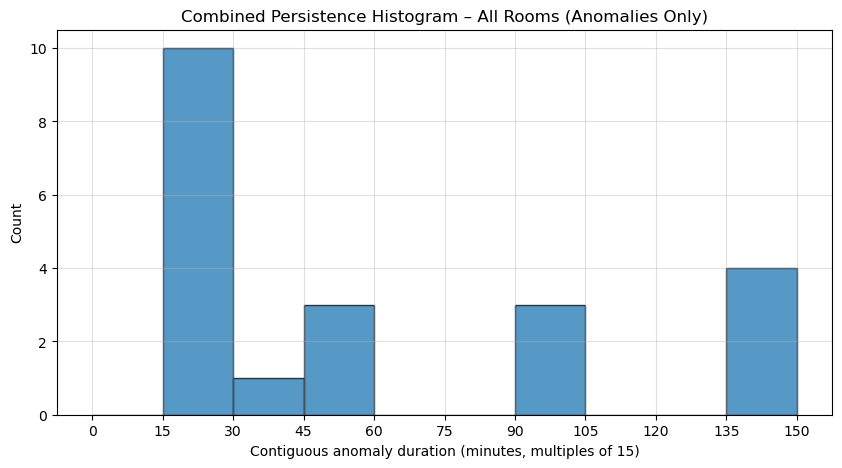

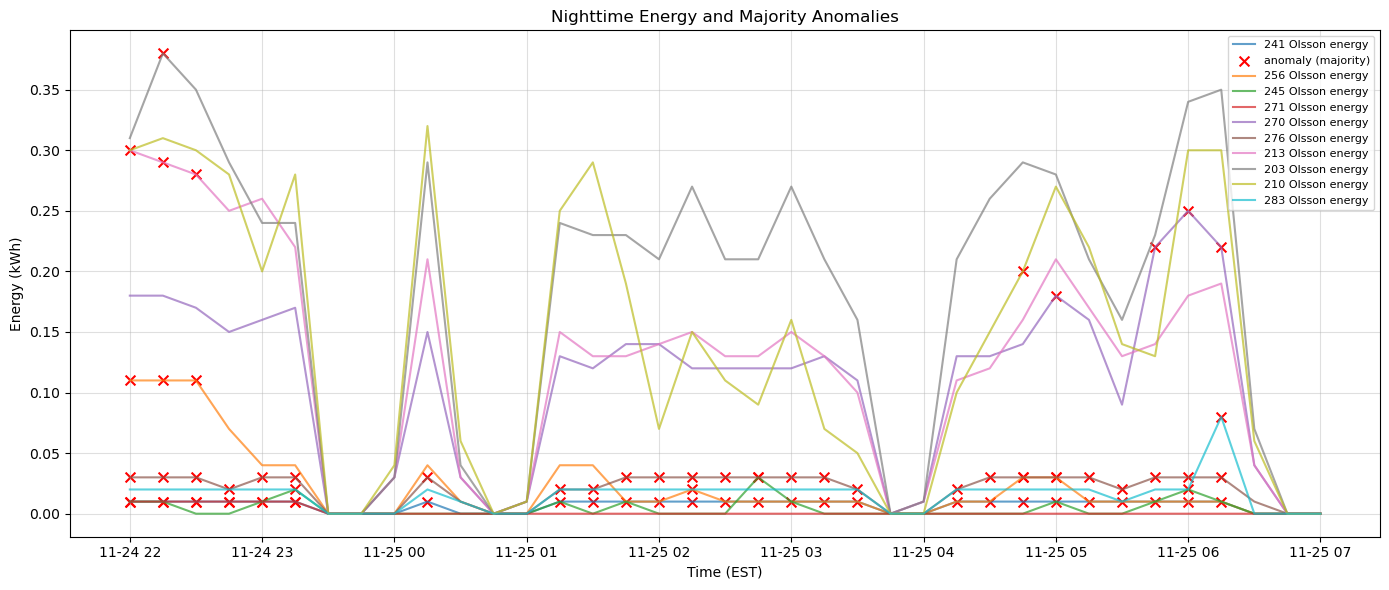

In [189]:
target_night = date(2025, 11, 24)  # Example: Nov 24, 2025
results_night = filter_single_night(results_by_room, target_night)

overall_metrics, per_room_metrics = compute_overall_metrics(results_night)
print(overall_metrics)
plot_combined_persistence_hist(results_night)
plot_night_flags_all_rooms(results_night)